# Init

In [1]:
%load_ext autoreload
%autoreload 2
import torch
from gfbm.layers.fBMGenerator import fBMGenerator
from gfbm.layers.BFlow import BFlowEncoder, BFlowMain
from gfbm.data_tools.datamodule import DataModule
import os
import numpy as np
import matplotlib.pyplot as plt
from fbm import fbm
import glob
import pytorch_lightning as pl
from umap import UMAP

# Old : with BF

In [1]:
import numpy as np

In [2]:
np.linspace(0,100,10,dtype=np.int)

array([  0,  11,  22,  33,  44,  55,  66,  77,  88, 100])

In [2]:
model_path = "%s/models/aout/BF_full_bs512_LR_1e-02_AD_aout_full-v9.ckpt" % os.environ["WORK"]
model = BFlowMain.load_from_checkpoint(model_path)
model.to("cuda")
model.eval()
model.freeze()

/gpfswork/rech/vjk/uxo83vo/models/aout/BF_diff_encoder_L1000_bs32_LR_1e-03_AD_aout_1000.ckpt
/gpfswork/rech/vjk/uxo83vo/models/aout/BF_alpha_encoder_L1000_bs384_LR_1e-04_AD_aout_1000.ckpt
f size =  [64, 128, 64, 32]
Convolution has 19296 parameters. Input dim is 32, output is 32


RuntimeError: Error(s) in loading state_dict for BFlowEncoder:
	size mismatch for summary_net.nodes_MLP.0.1.weight: copying a param with shape torch.Size([32, 10]) from checkpoint, the shape in current model is torch.Size([32, 7]).
	size mismatch for summary_net.nodes_MLP.2.1.weight: copying a param with shape torch.Size([10, 32]) from checkpoint, the shape in current model is torch.Size([7, 32]).
	size mismatch for summary_net.nodes_MLP.2.1.bias: copying a param with shape torch.Size([10]) from checkpoint, the shape in current model is torch.Size([7]).
	size mismatch for summary_net.nodes_MLP.2.2.weight: copying a param with shape torch.Size([10]) from checkpoint, the shape in current model is torch.Size([7]).
	size mismatch for summary_net.nodes_MLP.2.2.bias: copying a param with shape torch.Size([10]) from checkpoint, the shape in current model is torch.Size([7]).
	size mismatch for summary_net.nodes_MLP.2.2.running_mean: copying a param with shape torch.Size([10]) from checkpoint, the shape in current model is torch.Size([7]).
	size mismatch for summary_net.nodes_MLP.2.2.running_var: copying a param with shape torch.Size([10]) from checkpoint, the shape in current model is torch.Size([7]).
	size mismatch for summary_net.att_conv.weight: copying a param with shape torch.Size([10, 32]) from checkpoint, the shape in current model is torch.Size([7, 32]).

In [3]:
gen = fBMGenerator(dim=1)

In [4]:
from torch_geometric.data import Data, Batch
from gfbm.layers.diverse import batch_from_positions, batch_from_sub_batches

n_v = 104 # WARNING : n_v doit être divisible par BS
BS = 4
alpha_values = np.linspace(0.4,1.6,n_v,endpoint=True)
logdiffusion_values = np.linspace(-1,1,n_v//2,endpoint=True)

def get_posterior(model, traj):
    
    alpha, log_diff = np.meshgrid(alpha_values, logdiffusion_values)
    params = np.stack([np.reshape(alpha,(-1,)),np.reshape(log_diff,(-1,))],axis=-1)
    
    z2 = np.zeros(params.shape[0])
    
    h = None
    
    i = 0
    
    standard_batch = batch_from_positions(traj.float(),N=1,L=traj.shape[0],D=1,degree=model.hparams["degree"])
    x_standard = batch_from_sub_batches(min(BS,params.shape[0]-i)*[standard_batch]).to("cuda")
    theta_ = np.zeros(params.shape)
    
    while i < params.shape[0]:
        
        x = x_standard.clone()
        x.alpha = torch.from_numpy(params[i:min(i+BS,params.shape[0]),0]).view(-1,1).float()
        x.log_diffusion = torch.from_numpy(params[i:min(i+BS,params.shape[0]),1]).view(-1,1).float()
        x = x.to("cuda")
        x = model.compute_features(x)
        if i == 0:
            h = model.get_latent_vector(x)
        
        theta = model.make_theta(x)
        
        z, log_J = model.invertible_net(theta=theta, x=h, inverse=False)
        z2[i:min(i+BS,params.shape[0])] = torch.sum(z**2,dim=1).cpu().numpy()
        theta_[i:min(i+BS,params.shape[0])] = theta.cpu().numpy()
        i += BS
    
    z2 = np.reshape(z2,(logdiffusion_values.shape[0],alpha_values.shape[0]))
    posterior = np.exp(-z2/2.)
    posterior /= np.sum(posterior)
    return posterior, theta_, params

In [5]:
def estimate_on_trajs(model, T, alpha, n_trajs, n_samples, batch_size):
    i = 0
    inf_params = {"alpha":[],"log_diffusion":[]}
    while i < n_trajs:
        trajs = [torch.from_numpy(fbm(n=int(T-1),hurst=alpha/2.,length=T)).to(model.device).view(-1,1) for _ in range(batch_size)]
        #batch_idx = [torch.ones(trajs[j].shape[0],device=model.device)*(1+ j) for j in range(batch_size)]
        sub_batches = [batch_from_positions(traj.float(),
                                            N=1,
                                            L=traj.shape[0],
                                            D=1,degree=model.hparams["degree"]) for traj in trajs]
        batch = batch_from_sub_batches(sub_batches).to(model.device)
        batch = model.compute_features(batch)
        batch.alpha = torch.ones((batch_size,1),device=batch.pos.device)
        batch.log_diffusion = torch.ones((batch_size,1),device=batch.pos.device)
        
        inf_params_, true_params, _ = model.sample_step(batch.to(model.device),batch_idx=0, n_repeats=100)
        for k in inf_params:
            inf_params[k].append(np.reshape(inf_params_[k].cpu().numpy(),(batch.alpha.shape[0],-1)))
        
        i = i + batch_size
    for k in inf_params:
        inf_params[k] = np.concatenate(inf_params[k],axis=0)
    return inf_params

In [6]:
n_trajs = 10000
inf_params = {}
T_values = np.logspace(1,3,12,endpoint=True)
alphas = [.7,1.,1.3]
for T in T_values:
    print(T)
    for alpha in alphas:
        print("\t alpha = %.2f" % alpha)
        inf_params[(T,alpha)] = estimate_on_trajs(model.cuda(), T, alpha, n_trajs=n_trajs,n_samples=100, batch_size=20 if T <= 1000 else 1)

10.0
	 alpha = 0.70


/gpfslocalsup/pub/anaconda-py3/2020.02/envs/pytorch-gpu-1.8.0/lib/python3.7/site-packages/torch_sparse/storage.py:14: UserWarning: `layout` argument unset, using default layout "coo". This may lead to unexpected behaviour.
  warnings.warn('`layout` argument unset, using default layout '


	 alpha = 1.00
	 alpha = 1.30
15.199110829529339
	 alpha = 0.70
	 alpha = 1.00
	 alpha = 1.30
23.101297000831604
	 alpha = 0.70
	 alpha = 1.00
	 alpha = 1.30
35.11191734215131
	 alpha = 0.70
	 alpha = 1.00
	 alpha = 1.30
53.3669923120631
	 alpha = 0.70
	 alpha = 1.00
	 alpha = 1.30
81.11308307896873
	 alpha = 0.70
	 alpha = 1.00
	 alpha = 1.30
123.28467394420659
	 alpha = 0.70
	 alpha = 1.00
	 alpha = 1.30
187.3817422860383
	 alpha = 0.70
	 alpha = 1.00
	 alpha = 1.30
284.8035868435802
	 alpha = 0.70
	 alpha = 1.00
	 alpha = 1.30
432.87612810830615
	 alpha = 0.70
	 alpha = 1.00
	 alpha = 1.30
657.9332246575682
	 alpha = 0.70
	 alpha = 1.00
	 alpha = 1.30
1000.0
	 alpha = 0.70
	 alpha = 1.00
	 alpha = 1.30


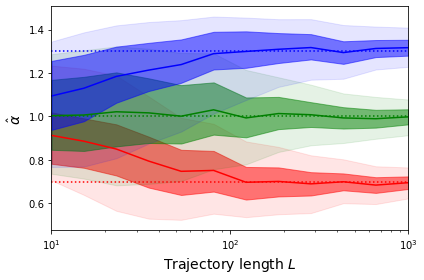

In [13]:
colors = ["red","green","blue"]
for c, alpha in zip(colors, alphas):
    plt.fill_between(x=T_values,
                     y1=[np.quantile(np.mean(inf_params[(T,alpha)]["alpha"],axis=1),0.05) for T in T_values],
                     y2=[np.quantile(np.mean(inf_params[(T,alpha)]["alpha"],axis=1),0.95) for T in T_values],alpha=.1,color=c)
    plt.fill_between(x=T_values,
                     y1=[np.quantile(np.mean(inf_params[(T,alpha)]["alpha"],axis=1),0.25) for T in T_values],
                     y2=[np.quantile(np.mean(inf_params[(T,alpha)]["alpha"],axis=1),0.75) for T in T_values],alpha=.5,color=c)
    
    plt.plot(T_values,[np.mean(inf_params[(T,alpha)]["alpha"]) for T in T_values],color=c)
    plt.axhline(alpha,c=c,ls=":")
plt.xlim((10,1000))
plt.xscale("log")
plt.ylabel("$\hat{\\alpha}$",fontsize=14)
plt.xlabel("Trajectory length $L$",fontsize=14)
plt.tight_layout()
plt.savefig("%s/paper-fbm/figures/alpha_convergence.pdf" % os.environ["SCRATCH"])

In [17]:
%timeit fbm(10000,.5)

508 µs ± 867 ns per loop (mean ± std. dev. of 7 runs, 1000 loops each)


# Train model

# Deterministic : load model trained on simple regression

In [69]:
files = glob.glob("%s/models/notebook/BF*015f*" % os.environ["WORK"])

In [70]:
files

['/gpfswork/rech/vjk/uxo83vo/models/notebook/BF_alpha_encoder_L1000_bs128_LR_1.0e-03_AD_noise_0.00_015f_notebook_1000.ckpt']

In [71]:
file = files[0]
print(file)

/gpfswork/rech/vjk/uxo83vo/models/notebook/BF_alpha_encoder_L1000_bs128_LR_1.0e-03_AD_noise_0.00_015f_notebook_1000.ckpt


In [2]:
file = "/gpfsdswork/projects/rech/vjk/uxo83vo/models/notebook/BF_alpha_encoder_L1000_bs128_LR_1.0e-02_AD_noise_0.00_44ea_notebook_1000.ckpt"

In [3]:
model = BFlowEncoder.load_from_checkpoint(file)
#model = BFlowEncoder(n_c=16,latent_dim=16,dim=1,skip_scales=True, scale_types=["step_sum"])
model.eval()
model.freeze()
model.to("cuda");
assert model.hparams["skip_scales"]

In [4]:
model.hparams

"T":            1000
"alpha_range":  (0.4, 1.6)
"degree":       20
"dim":          1
"e_dim":        5
"edge_method":  uniform_min_1000
"latent_dim":   16
"length_range": (10, 1001)
"lr":           0.01
"n_c":          32
"n_lengths":    16
"noise_sigma":  0.0
"scale_types":  ['step_sum']
"skip_scales":  True
"tau_range":    (1000, 1001)
"to_predict":   alpha
"vary_T":       True
"vary_tau":     False
"x_dim":        3

In [5]:
dm = DataModule(dl_params={"batch_size":8,"num_workers":12},
ds_params={"N": int(1e3),
           "dim": model.hparams["dim"],
           "length_range": (model.hparams["length_range"][1],100*model.hparams["length_range"][1]+1),
           #"length_range": (10,50),
           "vary_tau": False,
           "alpha_range": (.4, 1.6),
           "noise": model.hparams["noise_sigma"]},
graph_info={"edge_method": "uniform_min_%d" % model.hparams["T"],
            "degree": model.hparams["degree"]},
no_parallel=True)

In [6]:
trainer = pl.Trainer(auto_select_gpus=True,gpus=1)

GPU available: True, used: True
TPU available: False, using: 0 TPU cores


In [7]:
#predictions = trainer.predict(model,dataloaders=dm.predict_dataloader(no_parallel=True))
predictions = trainer.predict(model,datamodule=dm)
predictions = torch.cat(predictions,dim=0).cpu().numpy()

LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Prepare datasets
seed_offset = 1000
Prepare datasets
seed_offset = 1000
Test dataloader


Predicting: 0it [00:00, ?it/s]

/gpfslocalsup/pub/anaconda-py3/2021.05/envs/pytorch-gpu-1.9.0+py3.9/lib/python3.9/site-packages/torch_sparse/storage.py:14: UserWarning: `layout` argument unset, using default layout "coo". This may lead to unexpected behaviour.
  warnings.warn('`layout` argument unset, using default layout '


In [8]:
alpha_pred = predictions[:,2]
alpha_true = predictions[:,0]
length = predictions[:,1]

In [9]:
np.mean(np.abs(alpha_pred-alpha_true))

0.18565916

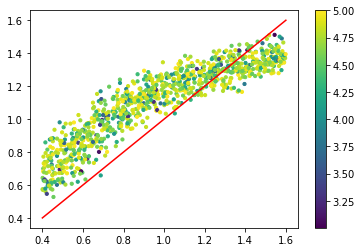

In [10]:
cm = plt.scatter(alpha_true, alpha_pred,c=np.log10(length),s=10)
plt.plot([0.4,1.6],[0.4,1.6],c="red")
plt.colorbar(cm)

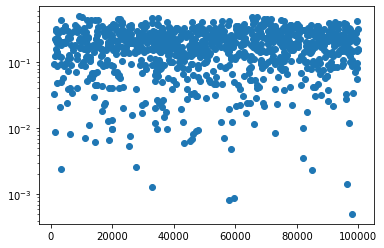

In [11]:
plt.scatter(length,np.abs(alpha_pred-alpha_true))
plt.yscale("log")

In [12]:
from sklearn.linear_model import LinearRegression

In [13]:
min_T = 10
max_T = int(1e5)

In [14]:
lms = {}

In [15]:
def batch_size(T):
    if T <= 500:
        return 64
    if T <= 1000:
        return 32
    elif T <= 10000:
        return 16
    elif T <= 100000:
        return 8
    else:
        return 2

LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


10
Prepare datasets
seed_offset = 2000
Prepare datasets
seed_offset = 2000
Test dataloader


Predicting: 0it [00:00, ?it/s]

[W pthreadpool-cpp.cc:90] Warning: Leaking Caffe2 thread-pool after fork. (function pthreadpool)
[W pthreadpool-cpp.cc:90] Warning: Leaking Caffe2 thread-pool after fork. (function pthreadpool)
[W pthreadpool-cpp.cc:90] Warning: Leaking Caffe2 thread-pool after fork. (function pthreadpool)
[W pthreadpool-cpp.cc:90] Warning: Leaking Caffe2 thread-pool after fork. (function pthreadpool)
[W pthreadpool-cpp.cc:90] Warning: Leaking Caffe2 thread-pool after fork. (function pthreadpool)
[W pthreadpool-cpp.cc:90] Warning: Leaking Caffe2 thread-pool after fork. (function pthreadpool)
[W pthreadpool-cpp.cc:90] Warning: Leaking Caffe2 thread-pool after fork. (function pthreadpool)
[W pthreadpool-cpp.cc:90] Warning: Leaking Caffe2 thread-pool after fork. (function pthreadpool)
[W pthreadpool-cpp.cc:90] Warning: Leaking Caffe2 thread-pool after fork. (function pthreadpool)
[W pthreadpool-cpp.cc:90] Warning: Leaking Caffe2 thread-pool after fork. (function pthreadpool)
[W pthreadpool-cpp.cc:90] Warn

27
Prepare datasets
seed_offset = 2000
Prepare datasets
seed_offset = 2000
Test dataloader


Predicting: 0it [00:00, ?it/s]

[W pthreadpool-cpp.cc:90] Warning: Leaking Caffe2 thread-pool after fork. (function pthreadpool)
[W pthreadpool-cpp.cc:90] Warning: Leaking Caffe2 thread-pool after fork. (function pthreadpool)
[W pthreadpool-cpp.cc:90] Warning: Leaking Caffe2 thread-pool after fork. (function pthreadpool)
[W pthreadpool-cpp.cc:90] Warning: Leaking Caffe2 thread-pool after fork. (function pthreadpool)
[W pthreadpool-cpp.cc:90] Warning: Leaking Caffe2 thread-pool after fork. (function pthreadpool)
[W pthreadpool-cpp.cc:90] Warning: Leaking Caffe2 thread-pool after fork. (function pthreadpool)
[W pthreadpool-cpp.cc:90] Warning: Leaking Caffe2 thread-pool after fork. (function pthreadpool)
[W pthreadpool-cpp.cc:90] Warning: Leaking Caffe2 thread-pool after fork. (function pthreadpool)
[W pthreadpool-cpp.cc:90] Warning: Leaking Caffe2 thread-pool after fork. (function pthreadpool)
[W pthreadpool-cpp.cc:90] Warning: Leaking Caffe2 thread-pool after fork. (function pthreadpool)
[W pthreadpool-cpp.cc:90] Warn

77
Prepare datasets
seed_offset = 2000
Prepare datasets
seed_offset = 2000
Test dataloader


Predicting: 0it [00:00, ?it/s]

[W pthreadpool-cpp.cc:90] Warning: Leaking Caffe2 thread-pool after fork. (function pthreadpool)
[W pthreadpool-cpp.cc:90] Warning: Leaking Caffe2 thread-pool after fork. (function pthreadpool)
[W pthreadpool-cpp.cc:90] Warning: Leaking Caffe2 thread-pool after fork. (function pthreadpool)
[W pthreadpool-cpp.cc:90] Warning: Leaking Caffe2 thread-pool after fork. (function pthreadpool)
[W pthreadpool-cpp.cc:90] Warning: Leaking Caffe2 thread-pool after fork. (function pthreadpool)
[W pthreadpool-cpp.cc:90] Warning: Leaking Caffe2 thread-pool after fork. (function pthreadpool)
[W pthreadpool-cpp.cc:90] Warning: Leaking Caffe2 thread-pool after fork. (function pthreadpool)
[W pthreadpool-cpp.cc:90] Warning: Leaking Caffe2 thread-pool after fork. (function pthreadpool)
[W pthreadpool-cpp.cc:90] Warning: Leaking Caffe2 thread-pool after fork. (function pthreadpool)
[W pthreadpool-cpp.cc:90] Warning: Leaking Caffe2 thread-pool after fork. (function pthreadpool)
[W pthreadpool-cpp.cc:90] Warn

215
Prepare datasets
seed_offset = 2000
Prepare datasets
seed_offset = 2000
Test dataloader


Predicting: 0it [00:00, ?it/s]

[W pthreadpool-cpp.cc:90] Warning: Leaking Caffe2 thread-pool after fork. (function pthreadpool)
[W pthreadpool-cpp.cc:90] Warning: Leaking Caffe2 thread-pool after fork. (function pthreadpool)
[W pthreadpool-cpp.cc:90] Warning: Leaking Caffe2 thread-pool after fork. (function pthreadpool)
[W pthreadpool-cpp.cc:90] Warning: Leaking Caffe2 thread-pool after fork. (function pthreadpool)
[W pthreadpool-cpp.cc:90] Warning: Leaking Caffe2 thread-pool after fork. (function pthreadpool)
[W pthreadpool-cpp.cc:90] Warning: Leaking Caffe2 thread-pool after fork. (function pthreadpool)
[W pthreadpool-cpp.cc:90] Warning: Leaking Caffe2 thread-pool after fork. (function pthreadpool)
[W pthreadpool-cpp.cc:90] Warning: Leaking Caffe2 thread-pool after fork. (function pthreadpool)
[W pthreadpool-cpp.cc:90] Warning: Leaking Caffe2 thread-pool after fork. (function pthreadpool)
[W pthreadpool-cpp.cc:90] Warning: Leaking Caffe2 thread-pool after fork. (function pthreadpool)
[W pthreadpool-cpp.cc:90] Warn

599
Prepare datasets
seed_offset = 2000
Prepare datasets
seed_offset = 2000
Test dataloader


Predicting: 0it [00:00, ?it/s]

[W pthreadpool-cpp.cc:90] Warning: Leaking Caffe2 thread-pool after fork. (function pthreadpool)
[W pthreadpool-cpp.cc:90] Warning: Leaking Caffe2 thread-pool after fork. (function pthreadpool)
[W pthreadpool-cpp.cc:90] Warning: Leaking Caffe2 thread-pool after fork. (function pthreadpool)
[W pthreadpool-cpp.cc:90] Warning: Leaking Caffe2 thread-pool after fork. (function pthreadpool)
[W pthreadpool-cpp.cc:90] Warning: Leaking Caffe2 thread-pool after fork. (function pthreadpool)
[W pthreadpool-cpp.cc:90] Warning: Leaking Caffe2 thread-pool after fork. (function pthreadpool)
[W pthreadpool-cpp.cc:90] Warning: Leaking Caffe2 thread-pool after fork. (function pthreadpool)
[W pthreadpool-cpp.cc:90] Warning: Leaking Caffe2 thread-pool after fork. (function pthreadpool)
[W pthreadpool-cpp.cc:90] Warning: Leaking Caffe2 thread-pool after fork. (function pthreadpool)
[W pthreadpool-cpp.cc:90] Warning: Leaking Caffe2 thread-pool after fork. (function pthreadpool)
[W pthreadpool-cpp.cc:90] Warn

1668
Prepare datasets
seed_offset = 2000
Prepare datasets
seed_offset = 2000
Test dataloader


Predicting: 0it [00:00, ?it/s]

[W pthreadpool-cpp.cc:90] Warning: Leaking Caffe2 thread-pool after fork. (function pthreadpool)
[W pthreadpool-cpp.cc:90] Warning: Leaking Caffe2 thread-pool after fork. (function pthreadpool)
[W pthreadpool-cpp.cc:90] Warning: Leaking Caffe2 thread-pool after fork. (function pthreadpool)
[W pthreadpool-cpp.cc:90] Warning: Leaking Caffe2 thread-pool after fork. (function pthreadpool)
[W pthreadpool-cpp.cc:90] Warning: Leaking Caffe2 thread-pool after fork. (function pthreadpool)
[W pthreadpool-cpp.cc:90] Warning: Leaking Caffe2 thread-pool after fork. (function pthreadpool)
[W pthreadpool-cpp.cc:90] Warning: Leaking Caffe2 thread-pool after fork. (function pthreadpool)
[W pthreadpool-cpp.cc:90] Warning: Leaking Caffe2 thread-pool after fork. (function pthreadpool)
[W pthreadpool-cpp.cc:90] Warning: Leaking Caffe2 thread-pool after fork. (function pthreadpool)
[W pthreadpool-cpp.cc:90] Warning: Leaking Caffe2 thread-pool after fork. (function pthreadpool)
[W pthreadpool-cpp.cc:90] Warn

4641
Prepare datasets
seed_offset = 2000
Prepare datasets
seed_offset = 2000
Test dataloader


Predicting: 0it [00:00, ?it/s]

[W pthreadpool-cpp.cc:90] Warning: Leaking Caffe2 thread-pool after fork. (function pthreadpool)
[W pthreadpool-cpp.cc:90] Warning: Leaking Caffe2 thread-pool after fork. (function pthreadpool)
[W pthreadpool-cpp.cc:90] Warning: Leaking Caffe2 thread-pool after fork. (function pthreadpool)
[W pthreadpool-cpp.cc:90] Warning: Leaking Caffe2 thread-pool after fork. (function pthreadpool)
[W pthreadpool-cpp.cc:90] Warning: Leaking Caffe2 thread-pool after fork. (function pthreadpool)
[W pthreadpool-cpp.cc:90] Warning: Leaking Caffe2 thread-pool after fork. (function pthreadpool)
[W pthreadpool-cpp.cc:90] Warning: Leaking Caffe2 thread-pool after fork. (function pthreadpool)
[W pthreadpool-cpp.cc:90] Warning: Leaking Caffe2 thread-pool after fork. (function pthreadpool)
[W pthreadpool-cpp.cc:90] Warning: Leaking Caffe2 thread-pool after fork. (function pthreadpool)
[W pthreadpool-cpp.cc:90] Warning: Leaking Caffe2 thread-pool after fork. (function pthreadpool)
[W pthreadpool-cpp.cc:90] Warn

12915
Prepare datasets
seed_offset = 2000
Prepare datasets
seed_offset = 2000
Test dataloader


Predicting: 0it [00:00, ?it/s]

[W pthreadpool-cpp.cc:90] Warning: Leaking Caffe2 thread-pool after fork. (function pthreadpool)
[W pthreadpool-cpp.cc:90] Warning: Leaking Caffe2 thread-pool after fork. (function pthreadpool)
[W pthreadpool-cpp.cc:90] Warning: Leaking Caffe2 thread-pool after fork. (function pthreadpool)
[W pthreadpool-cpp.cc:90] Warning: Leaking Caffe2 thread-pool after fork. (function pthreadpool)
[W pthreadpool-cpp.cc:90] Warning: Leaking Caffe2 thread-pool after fork. (function pthreadpool)
[W pthreadpool-cpp.cc:90] Warning: Leaking Caffe2 thread-pool after fork. (function pthreadpool)
[W pthreadpool-cpp.cc:90] Warning: Leaking Caffe2 thread-pool after fork. (function pthreadpool)
[W pthreadpool-cpp.cc:90] Warning: Leaking Caffe2 thread-pool after fork. (function pthreadpool)
[W pthreadpool-cpp.cc:90] Warning: Leaking Caffe2 thread-pool after fork. (function pthreadpool)
[W pthreadpool-cpp.cc:90] Warning: Leaking Caffe2 thread-pool after fork. (function pthreadpool)
[W pthreadpool-cpp.cc:90] Warn

35938
Prepare datasets
seed_offset = 2000
Prepare datasets
seed_offset = 2000
Test dataloader


Predicting: 0it [00:00, ?it/s]

[W pthreadpool-cpp.cc:90] Warning: Leaking Caffe2 thread-pool after fork. (function pthreadpool)
[W pthreadpool-cpp.cc:90] Warning: Leaking Caffe2 thread-pool after fork. (function pthreadpool)
[W pthreadpool-cpp.cc:90] Warning: Leaking Caffe2 thread-pool after fork. (function pthreadpool)
[W pthreadpool-cpp.cc:90] Warning: Leaking Caffe2 thread-pool after fork. (function pthreadpool)
[W pthreadpool-cpp.cc:90] Warning: Leaking Caffe2 thread-pool after fork. (function pthreadpool)
[W pthreadpool-cpp.cc:90] Warning: Leaking Caffe2 thread-pool after fork. (function pthreadpool)
[W pthreadpool-cpp.cc:90] Warning: Leaking Caffe2 thread-pool after fork. (function pthreadpool)
[W pthreadpool-cpp.cc:90] Warning: Leaking Caffe2 thread-pool after fork. (function pthreadpool)
[W pthreadpool-cpp.cc:90] Warning: Leaking Caffe2 thread-pool after fork. (function pthreadpool)
[W pthreadpool-cpp.cc:90] Warning: Leaking Caffe2 thread-pool after fork. (function pthreadpool)
[W pthreadpool-cpp.cc:90] Warn

100000
Prepare datasets
seed_offset = 2000
Prepare datasets
seed_offset = 2000
Test dataloader


Predicting: 0it [00:00, ?it/s]

[W pthreadpool-cpp.cc:90] Warning: Leaking Caffe2 thread-pool after fork. (function pthreadpool)
[W pthreadpool-cpp.cc:90] Warning: Leaking Caffe2 thread-pool after fork. (function pthreadpool)
[W pthreadpool-cpp.cc:90] Warning: Leaking Caffe2 thread-pool after fork. (function pthreadpool)
[W pthreadpool-cpp.cc:90] Warning: Leaking Caffe2 thread-pool after fork. (function pthreadpool)
[W pthreadpool-cpp.cc:90] Warning: Leaking Caffe2 thread-pool after fork. (function pthreadpool)
[W pthreadpool-cpp.cc:90] Warning: Leaking Caffe2 thread-pool after fork. (function pthreadpool)
[W pthreadpool-cpp.cc:90] Warning: Leaking Caffe2 thread-pool after fork. (function pthreadpool)
[W pthreadpool-cpp.cc:90] Warning: Leaking Caffe2 thread-pool after fork. (function pthreadpool)
[W pthreadpool-cpp.cc:90] Warning: Leaking Caffe2 thread-pool after fork. (function pthreadpool)
[W pthreadpool-cpp.cc:90] Warning: Leaking Caffe2 thread-pool after fork. (function pthreadpool)
[W pthreadpool-cpp.cc:90] Warn

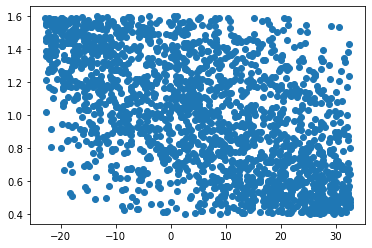

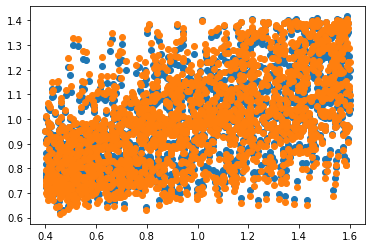

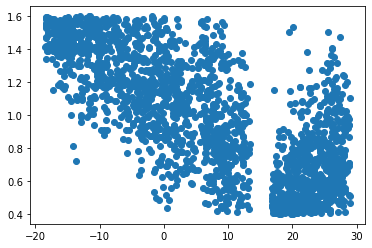

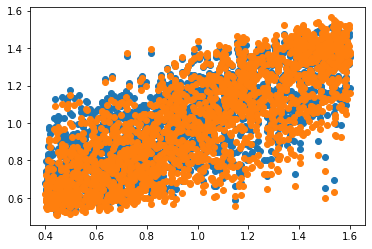

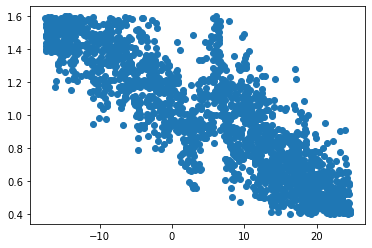

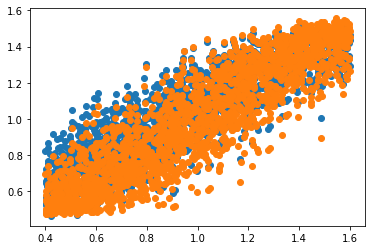

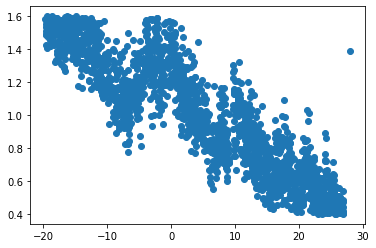

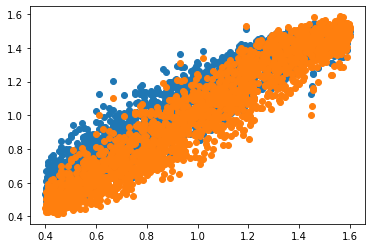

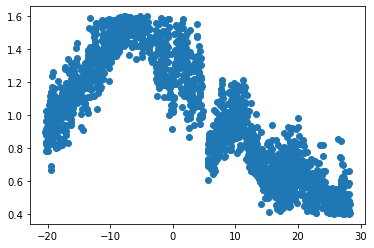

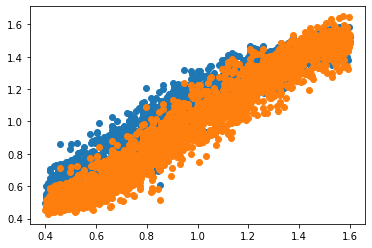

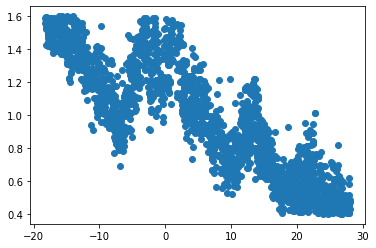

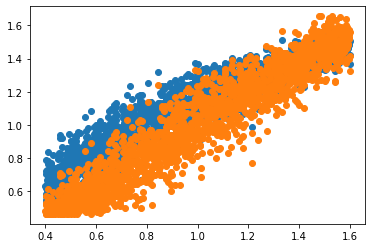

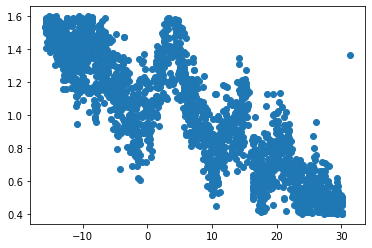

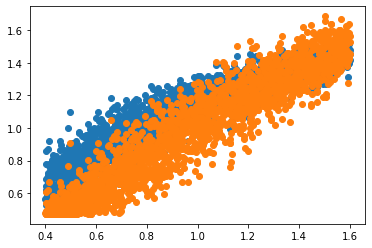

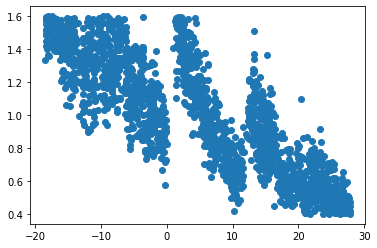

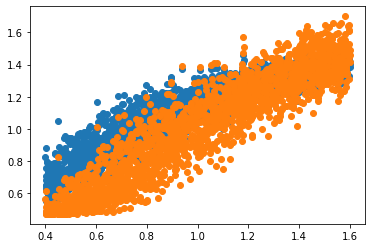

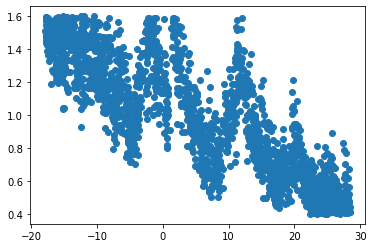

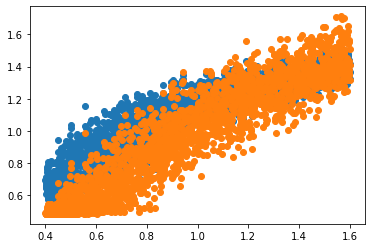

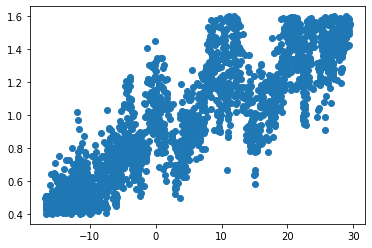

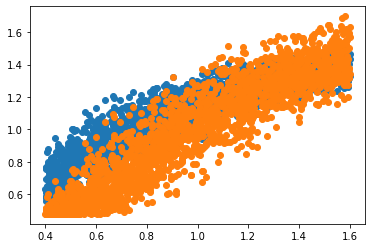

In [16]:
alpha_values = [0.7,1.,1.3]
T_values = np.logspace(np.log10(min_T),np.log10(max_T),10,dtype=int)

for T in T_values:
    if T in lms: continue
    print(T)
    dm = DataModule(dl_params={"batch_size":batch_size(T),"num_workers":12},
        ds_params={"N": int(2e3),
               "dim": model.hparams["dim"],
               "length_range": (T,T+1),
               #"length_range": (10,50),
               "vary_tau": False,
               "alpha_range": (.4, 1.6),
               "noise": model.hparams["noise_sigma"]},
            graph_info={"edge_method": "uniform_min_%d" % model.hparams["T"],
                        "degree": model.hparams["degree"]},
        no_parallel=True)
    predictions = trainer.predict(model,datamodule=dm)
    predictions = torch.cat(predictions,dim=0).cpu().numpy()

    alpha_pred = predictions[:,2]
    alpha_true = predictions[:,0]
    h = predictions[:,3:]
    
    plt.figure()
    X_ = UMAP(n_components=1,min_dist=.2,n_neighbors=30).fit_transform(h)
    plt.scatter(X_[:,0],alpha_true)
    #plt.scatter(X_[:,0],X_[:,1],c=alpha_true)

    lm = LinearRegression()

    X = np.stack([alpha_pred,alpha_pred**2,alpha_pred**3],axis=1)

    lm.fit(X, alpha_true)
    plt.figure()
    plt.scatter(alpha_true,alpha_pred)
    alpha_adjusted = lm.predict(X)
    plt.scatter(alpha_true,alpha_adjusted)
    lms[T] = lm

In [17]:
for T in lms:
    print(lms[T].coef_)

[-2.4887931  3.7375135 -1.2628642]
[-0.69755924  1.4760956  -0.37118006]
[-1.7637702  2.5322134 -0.6936242]
[ 0.00817245  0.6374035  -0.06326389]
[0.15772432 0.37753993 0.04299106]
[-2.1124852   2.429485   -0.51145023]
[-3.4730668   3.6619704  -0.84134287]
[-3.2495704  3.2865481 -0.6641087]
[-3.9213946   3.8198295  -0.78532094]
[-4.215414    4.127771   -0.87854475]


In [18]:
alpha_values = [0.7,1.,1.3]
alpha_preds = {}
alpha_trues = {}
for i, alpha in enumerate(alpha_values):
    for T in T_values:
        print(alpha, T)
        dm = DataModule(dl_params={"batch_size":batch_size(T),"num_workers":12},
            ds_params={"N": int(3e2),
               "dim": model.hparams["dim"],
               "length_range": (T,T+1),
               #"length_range": (10,50),
               "vary_tau": False,
               "alpha_range": (alpha, alpha),
               "noise": model.hparams["noise_sigma"]},
            graph_info={"edge_method": "uniform_min_%d" % model.hparams["T"],
                        "degree": model.hparams["degree"]},
            no_parallel=True)
        predictions = trainer.predict(model,datamodule=dm)
        predictions = torch.cat(predictions,dim=0).cpu().numpy()

        alpha_pred = predictions[:,2]
        alpha_true = predictions[:,0]
        h = predictions[:,3:]
        
        print(np.mean(np.abs(alpha_pred-alpha_true)))
        X = np.stack([alpha_pred,alpha_pred**2,alpha_pred**3],axis=1)
        alpha_pred = lms[T].predict(X)
        
        alpha_preds[(i,T)] = alpha_pred
        alpha_trues[(i,T)] = alpha_true

LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


0.7 10
Prepare datasets
seed_offset = 300
Prepare datasets
seed_offset = 300
Test dataloader


Predicting: 0it [00:00, ?it/s]

[W pthreadpool-cpp.cc:90] Warning: Leaking Caffe2 thread-pool after fork. (function pthreadpool)
[W pthreadpool-cpp.cc:90] Warning: Leaking Caffe2 thread-pool after fork. (function pthreadpool)
[W pthreadpool-cpp.cc:90] Warning: Leaking Caffe2 thread-pool after fork. (function pthreadpool)
[W pthreadpool-cpp.cc:90] Warning: Leaking Caffe2 thread-pool after fork. (function pthreadpool)
[W pthreadpool-cpp.cc:90] Warning: Leaking Caffe2 thread-pool after fork. (function pthreadpool)
[W pthreadpool-cpp.cc:90] Warning: Leaking Caffe2 thread-pool after fork. (function pthreadpool)
[W pthreadpool-cpp.cc:90] Warning: Leaking Caffe2 thread-pool after fork. (function pthreadpool)
[W pthreadpool-cpp.cc:90] Warning: Leaking Caffe2 thread-pool after fork. (function pthreadpool)
[W pthreadpool-cpp.cc:90] Warning: Leaking Caffe2 thread-pool after fork. (function pthreadpool)
[W pthreadpool-cpp.cc:90] Warning: Leaking Caffe2 thread-pool after fork. (function pthreadpool)
[W pthreadpool-cpp.cc:90] Warn

0.21073848
0.7 27
Prepare datasets
seed_offset = 300
Prepare datasets
seed_offset = 300
Test dataloader


Predicting: 0it [00:00, ?it/s]

[W pthreadpool-cpp.cc:90] Warning: Leaking Caffe2 thread-pool after fork. (function pthreadpool)
[W pthreadpool-cpp.cc:90] Warning: Leaking Caffe2 thread-pool after fork. (function pthreadpool)
[W pthreadpool-cpp.cc:90] Warning: Leaking Caffe2 thread-pool after fork. (function pthreadpool)
[W pthreadpool-cpp.cc:90] Warning: Leaking Caffe2 thread-pool after fork. (function pthreadpool)
[W pthreadpool-cpp.cc:90] Warning: Leaking Caffe2 thread-pool after fork. (function pthreadpool)
[W pthreadpool-cpp.cc:90] Warning: Leaking Caffe2 thread-pool after fork. (function pthreadpool)
[W pthreadpool-cpp.cc:90] Warning: Leaking Caffe2 thread-pool after fork. (function pthreadpool)
[W pthreadpool-cpp.cc:90] Warning: Leaking Caffe2 thread-pool after fork. (function pthreadpool)
[W pthreadpool-cpp.cc:90] Warning: Leaking Caffe2 thread-pool after fork. (function pthreadpool)
[W pthreadpool-cpp.cc:90] Warning: Leaking Caffe2 thread-pool after fork. (function pthreadpool)
[W pthreadpool-cpp.cc:90] Warn

0.1770033
0.7 77
Prepare datasets
seed_offset = 300
Prepare datasets
seed_offset = 300
Test dataloader


Predicting: 0it [00:00, ?it/s]

[W pthreadpool-cpp.cc:90] Warning: Leaking Caffe2 thread-pool after fork. (function pthreadpool)
[W pthreadpool-cpp.cc:90] Warning: Leaking Caffe2 thread-pool after fork. (function pthreadpool)
[W pthreadpool-cpp.cc:90] Warning: Leaking Caffe2 thread-pool after fork. (function pthreadpool)
[W pthreadpool-cpp.cc:90] Warning: Leaking Caffe2 thread-pool after fork. (function pthreadpool)
[W pthreadpool-cpp.cc:90] Warning: Leaking Caffe2 thread-pool after fork. (function pthreadpool)
[W pthreadpool-cpp.cc:90] Warning: Leaking Caffe2 thread-pool after fork. (function pthreadpool)
[W pthreadpool-cpp.cc:90] Warning: Leaking Caffe2 thread-pool after fork. (function pthreadpool)
[W pthreadpool-cpp.cc:90] Warning: Leaking Caffe2 thread-pool after fork. (function pthreadpool)
[W pthreadpool-cpp.cc:90] Warning: Leaking Caffe2 thread-pool after fork. (function pthreadpool)
[W pthreadpool-cpp.cc:90] Warning: Leaking Caffe2 thread-pool after fork. (function pthreadpool)
[W pthreadpool-cpp.cc:90] Warn

0.17221856
0.7 215
Prepare datasets
seed_offset = 300
Prepare datasets
seed_offset = 300
Test dataloader


Predicting: 0it [00:00, ?it/s]

[W pthreadpool-cpp.cc:90] Warning: Leaking Caffe2 thread-pool after fork. (function pthreadpool)
[W pthreadpool-cpp.cc:90] Warning: Leaking Caffe2 thread-pool after fork. (function pthreadpool)
[W pthreadpool-cpp.cc:90] Warning: Leaking Caffe2 thread-pool after fork. (function pthreadpool)
[W pthreadpool-cpp.cc:90] Warning: Leaking Caffe2 thread-pool after fork. (function pthreadpool)
[W pthreadpool-cpp.cc:90] Warning: Leaking Caffe2 thread-pool after fork. (function pthreadpool)
[W pthreadpool-cpp.cc:90] Warning: Leaking Caffe2 thread-pool after fork. (function pthreadpool)
[W pthreadpool-cpp.cc:90] Warning: Leaking Caffe2 thread-pool after fork. (function pthreadpool)
[W pthreadpool-cpp.cc:90] Warning: Leaking Caffe2 thread-pool after fork. (function pthreadpool)
[W pthreadpool-cpp.cc:90] Warning: Leaking Caffe2 thread-pool after fork. (function pthreadpool)
[W pthreadpool-cpp.cc:90] Warning: Leaking Caffe2 thread-pool after fork. (function pthreadpool)
[W pthreadpool-cpp.cc:90] Warn

0.17244019
0.7 599
Prepare datasets
seed_offset = 300
Prepare datasets
seed_offset = 300
Test dataloader


Predicting: 0it [00:00, ?it/s]

[W pthreadpool-cpp.cc:90] Warning: Leaking Caffe2 thread-pool after fork. (function pthreadpool)
[W pthreadpool-cpp.cc:90] Warning: Leaking Caffe2 thread-pool after fork. (function pthreadpool)
[W pthreadpool-cpp.cc:90] Warning: Leaking Caffe2 thread-pool after fork. (function pthreadpool)
[W pthreadpool-cpp.cc:90] Warning: Leaking Caffe2 thread-pool after fork. (function pthreadpool)
[W pthreadpool-cpp.cc:90] Warning: Leaking Caffe2 thread-pool after fork. (function pthreadpool)
[W pthreadpool-cpp.cc:90] Warning: Leaking Caffe2 thread-pool after fork. (function pthreadpool)
[W pthreadpool-cpp.cc:90] Warning: Leaking Caffe2 thread-pool after fork. (function pthreadpool)
[W pthreadpool-cpp.cc:90] Warning: Leaking Caffe2 thread-pool after fork. (function pthreadpool)
[W pthreadpool-cpp.cc:90] Warning: Leaking Caffe2 thread-pool after fork. (function pthreadpool)
[W pthreadpool-cpp.cc:90] Warning: Leaking Caffe2 thread-pool after fork. (function pthreadpool)
[W pthreadpool-cpp.cc:90] Warn

0.13804708
0.7 1668
Prepare datasets
seed_offset = 300
Prepare datasets
seed_offset = 300
Test dataloader


Predicting: 0it [00:00, ?it/s]

[W pthreadpool-cpp.cc:90] Warning: Leaking Caffe2 thread-pool after fork. (function pthreadpool)
[W pthreadpool-cpp.cc:90] Warning: Leaking Caffe2 thread-pool after fork. (function pthreadpool)
[W pthreadpool-cpp.cc:90] Warning: Leaking Caffe2 thread-pool after fork. (function pthreadpool)
[W pthreadpool-cpp.cc:90] Warning: Leaking Caffe2 thread-pool after fork. (function pthreadpool)
[W pthreadpool-cpp.cc:90] Warning: Leaking Caffe2 thread-pool after fork. (function pthreadpool)
[W pthreadpool-cpp.cc:90] Warning: Leaking Caffe2 thread-pool after fork. (function pthreadpool)
[W pthreadpool-cpp.cc:90] Warning: Leaking Caffe2 thread-pool after fork. (function pthreadpool)
[W pthreadpool-cpp.cc:90] Warning: Leaking Caffe2 thread-pool after fork. (function pthreadpool)
[W pthreadpool-cpp.cc:90] Warning: Leaking Caffe2 thread-pool after fork. (function pthreadpool)
[W pthreadpool-cpp.cc:90] Warning: Leaking Caffe2 thread-pool after fork. (function pthreadpool)
[W pthreadpool-cpp.cc:90] Warn

0.22924498
0.7 4641
Prepare datasets
seed_offset = 300
Prepare datasets
seed_offset = 300
Test dataloader


Predicting: 0it [00:00, ?it/s]

[W pthreadpool-cpp.cc:90] Warning: Leaking Caffe2 thread-pool after fork. (function pthreadpool)
[W pthreadpool-cpp.cc:90] Warning: Leaking Caffe2 thread-pool after fork. (function pthreadpool)
[W pthreadpool-cpp.cc:90] Warning: Leaking Caffe2 thread-pool after fork. (function pthreadpool)
[W pthreadpool-cpp.cc:90] Warning: Leaking Caffe2 thread-pool after fork. (function pthreadpool)
[W pthreadpool-cpp.cc:90] Warning: Leaking Caffe2 thread-pool after fork. (function pthreadpool)
[W pthreadpool-cpp.cc:90] Warning: Leaking Caffe2 thread-pool after fork. (function pthreadpool)
[W pthreadpool-cpp.cc:90] Warning: Leaking Caffe2 thread-pool after fork. (function pthreadpool)
[W pthreadpool-cpp.cc:90] Warning: Leaking Caffe2 thread-pool after fork. (function pthreadpool)
[W pthreadpool-cpp.cc:90] Warning: Leaking Caffe2 thread-pool after fork. (function pthreadpool)
[W pthreadpool-cpp.cc:90] Warning: Leaking Caffe2 thread-pool after fork. (function pthreadpool)
[W pthreadpool-cpp.cc:90] Warn

0.24367632
0.7 12915
Prepare datasets
seed_offset = 300
Prepare datasets
seed_offset = 300
Test dataloader


Predicting: 0it [00:00, ?it/s]

[W pthreadpool-cpp.cc:90] Warning: Leaking Caffe2 thread-pool after fork. (function pthreadpool)
[W pthreadpool-cpp.cc:90] Warning: Leaking Caffe2 thread-pool after fork. (function pthreadpool)
[W pthreadpool-cpp.cc:90] Warning: Leaking Caffe2 thread-pool after fork. (function pthreadpool)
[W pthreadpool-cpp.cc:90] Warning: Leaking Caffe2 thread-pool after fork. (function pthreadpool)
[W pthreadpool-cpp.cc:90] Warning: Leaking Caffe2 thread-pool after fork. (function pthreadpool)
[W pthreadpool-cpp.cc:90] Warning: Leaking Caffe2 thread-pool after fork. (function pthreadpool)
[W pthreadpool-cpp.cc:90] Warning: Leaking Caffe2 thread-pool after fork. (function pthreadpool)
[W pthreadpool-cpp.cc:90] Warning: Leaking Caffe2 thread-pool after fork. (function pthreadpool)
[W pthreadpool-cpp.cc:90] Warning: Leaking Caffe2 thread-pool after fork. (function pthreadpool)
[W pthreadpool-cpp.cc:90] Warning: Leaking Caffe2 thread-pool after fork. (function pthreadpool)
[W pthreadpool-cpp.cc:90] Warn

0.26014215
0.7 35938
Prepare datasets
seed_offset = 300
Prepare datasets
seed_offset = 300
Test dataloader


Predicting: 0it [00:00, ?it/s]

[W pthreadpool-cpp.cc:90] Warning: Leaking Caffe2 thread-pool after fork. (function pthreadpool)
[W pthreadpool-cpp.cc:90] Warning: Leaking Caffe2 thread-pool after fork. (function pthreadpool)
[W pthreadpool-cpp.cc:90] Warning: Leaking Caffe2 thread-pool after fork. (function pthreadpool)
[W pthreadpool-cpp.cc:90] Warning: Leaking Caffe2 thread-pool after fork. (function pthreadpool)
[W pthreadpool-cpp.cc:90] Warning: Leaking Caffe2 thread-pool after fork. (function pthreadpool)
[W pthreadpool-cpp.cc:90] Warning: Leaking Caffe2 thread-pool after fork. (function pthreadpool)
[W pthreadpool-cpp.cc:90] Warning: Leaking Caffe2 thread-pool after fork. (function pthreadpool)
[W pthreadpool-cpp.cc:90] Warning: Leaking Caffe2 thread-pool after fork. (function pthreadpool)
[W pthreadpool-cpp.cc:90] Warning: Leaking Caffe2 thread-pool after fork. (function pthreadpool)
[W pthreadpool-cpp.cc:90] Warning: Leaking Caffe2 thread-pool after fork. (function pthreadpool)
[W pthreadpool-cpp.cc:90] Warn

0.26346186
0.7 100000
Prepare datasets
seed_offset = 300
Prepare datasets
seed_offset = 300
Test dataloader


Predicting: 0it [00:00, ?it/s]

[W pthreadpool-cpp.cc:90] Warning: Leaking Caffe2 thread-pool after fork. (function pthreadpool)
[W pthreadpool-cpp.cc:90] Warning: Leaking Caffe2 thread-pool after fork. (function pthreadpool)
[W pthreadpool-cpp.cc:90] Warning: Leaking Caffe2 thread-pool after fork. (function pthreadpool)
[W pthreadpool-cpp.cc:90] Warning: Leaking Caffe2 thread-pool after fork. (function pthreadpool)
[W pthreadpool-cpp.cc:90] Warning: Leaking Caffe2 thread-pool after fork. (function pthreadpool)
[W pthreadpool-cpp.cc:90] Warning: Leaking Caffe2 thread-pool after fork. (function pthreadpool)
[W pthreadpool-cpp.cc:90] Warning: Leaking Caffe2 thread-pool after fork. (function pthreadpool)
[W pthreadpool-cpp.cc:90] Warning: Leaking Caffe2 thread-pool after fork. (function pthreadpool)
[W pthreadpool-cpp.cc:90] Warning: Leaking Caffe2 thread-pool after fork. (function pthreadpool)
[W pthreadpool-cpp.cc:90] Warning: Leaking Caffe2 thread-pool after fork. (function pthreadpool)
[W pthreadpool-cpp.cc:90] Warn

0.27185017
1.0 10
Prepare datasets
seed_offset = 300
Prepare datasets
seed_offset = 300
Test dataloader


Predicting: 0it [00:00, ?it/s]

[W pthreadpool-cpp.cc:90] Warning: Leaking Caffe2 thread-pool after fork. (function pthreadpool)
[W pthreadpool-cpp.cc:90] Warning: Leaking Caffe2 thread-pool after fork. (function pthreadpool)
[W pthreadpool-cpp.cc:90] Warning: Leaking Caffe2 thread-pool after fork. (function pthreadpool)
[W pthreadpool-cpp.cc:90] Warning: Leaking Caffe2 thread-pool after fork. (function pthreadpool)
[W pthreadpool-cpp.cc:90] Warning: Leaking Caffe2 thread-pool after fork. (function pthreadpool)
[W pthreadpool-cpp.cc:90] Warning: Leaking Caffe2 thread-pool after fork. (function pthreadpool)
[W pthreadpool-cpp.cc:90] Warning: Leaking Caffe2 thread-pool after fork. (function pthreadpool)
[W pthreadpool-cpp.cc:90] Warning: Leaking Caffe2 thread-pool after fork. (function pthreadpool)
[W pthreadpool-cpp.cc:90] Warning: Leaking Caffe2 thread-pool after fork. (function pthreadpool)
[W pthreadpool-cpp.cc:90] Warning: Leaking Caffe2 thread-pool after fork. (function pthreadpool)
[W pthreadpool-cpp.cc:90] Warn

0.117640845
1.0 27
Prepare datasets
seed_offset = 300
Prepare datasets
seed_offset = 300
Test dataloader


Predicting: 0it [00:00, ?it/s]

[W pthreadpool-cpp.cc:90] Warning: Leaking Caffe2 thread-pool after fork. (function pthreadpool)
[W pthreadpool-cpp.cc:90] Warning: Leaking Caffe2 thread-pool after fork. (function pthreadpool)
[W pthreadpool-cpp.cc:90] Warning: Leaking Caffe2 thread-pool after fork. (function pthreadpool)
[W pthreadpool-cpp.cc:90] Warning: Leaking Caffe2 thread-pool after fork. (function pthreadpool)
[W pthreadpool-cpp.cc:90] Warning: Leaking Caffe2 thread-pool after fork. (function pthreadpool)
[W pthreadpool-cpp.cc:90] Warning: Leaking Caffe2 thread-pool after fork. (function pthreadpool)
[W pthreadpool-cpp.cc:90] Warning: Leaking Caffe2 thread-pool after fork. (function pthreadpool)
[W pthreadpool-cpp.cc:90] Warning: Leaking Caffe2 thread-pool after fork. (function pthreadpool)
[W pthreadpool-cpp.cc:90] Warning: Leaking Caffe2 thread-pool after fork. (function pthreadpool)
[W pthreadpool-cpp.cc:90] Warning: Leaking Caffe2 thread-pool after fork. (function pthreadpool)
[W pthreadpool-cpp.cc:90] Warn

0.1446235
1.0 77
Prepare datasets
seed_offset = 300
Prepare datasets
seed_offset = 300
Test dataloader


Predicting: 0it [00:00, ?it/s]

[W pthreadpool-cpp.cc:90] Warning: Leaking Caffe2 thread-pool after fork. (function pthreadpool)
[W pthreadpool-cpp.cc:90] Warning: Leaking Caffe2 thread-pool after fork. (function pthreadpool)
[W pthreadpool-cpp.cc:90] Warning: Leaking Caffe2 thread-pool after fork. (function pthreadpool)
[W pthreadpool-cpp.cc:90] Warning: Leaking Caffe2 thread-pool after fork. (function pthreadpool)
[W pthreadpool-cpp.cc:90] Warning: Leaking Caffe2 thread-pool after fork. (function pthreadpool)
[W pthreadpool-cpp.cc:90] Warning: Leaking Caffe2 thread-pool after fork. (function pthreadpool)
[W pthreadpool-cpp.cc:90] Warning: Leaking Caffe2 thread-pool after fork. (function pthreadpool)
[W pthreadpool-cpp.cc:90] Warning: Leaking Caffe2 thread-pool after fork. (function pthreadpool)
[W pthreadpool-cpp.cc:90] Warning: Leaking Caffe2 thread-pool after fork. (function pthreadpool)
[W pthreadpool-cpp.cc:90] Warning: Leaking Caffe2 thread-pool after fork. (function pthreadpool)
[W pthreadpool-cpp.cc:90] Warn

0.13420394
1.0 215
Prepare datasets
seed_offset = 300
Prepare datasets
seed_offset = 300
Test dataloader


Predicting: 0it [00:00, ?it/s]

[W pthreadpool-cpp.cc:90] Warning: Leaking Caffe2 thread-pool after fork. (function pthreadpool)
[W pthreadpool-cpp.cc:90] Warning: Leaking Caffe2 thread-pool after fork. (function pthreadpool)
[W pthreadpool-cpp.cc:90] Warning: Leaking Caffe2 thread-pool after fork. (function pthreadpool)
[W pthreadpool-cpp.cc:90] Warning: Leaking Caffe2 thread-pool after fork. (function pthreadpool)
[W pthreadpool-cpp.cc:90] Warning: Leaking Caffe2 thread-pool after fork. (function pthreadpool)
[W pthreadpool-cpp.cc:90] Warning: Leaking Caffe2 thread-pool after fork. (function pthreadpool)
[W pthreadpool-cpp.cc:90] Warning: Leaking Caffe2 thread-pool after fork. (function pthreadpool)
[W pthreadpool-cpp.cc:90] Warning: Leaking Caffe2 thread-pool after fork. (function pthreadpool)
[W pthreadpool-cpp.cc:90] Warning: Leaking Caffe2 thread-pool after fork. (function pthreadpool)
[W pthreadpool-cpp.cc:90] Warning: Leaking Caffe2 thread-pool after fork. (function pthreadpool)
[W pthreadpool-cpp.cc:90] Warn

0.13797247
1.0 599
Prepare datasets
seed_offset = 300
Prepare datasets
seed_offset = 300
Test dataloader


Predicting: 0it [00:00, ?it/s]

[W pthreadpool-cpp.cc:90] Warning: Leaking Caffe2 thread-pool after fork. (function pthreadpool)
[W pthreadpool-cpp.cc:90] Warning: Leaking Caffe2 thread-pool after fork. (function pthreadpool)
[W pthreadpool-cpp.cc:90] Warning: Leaking Caffe2 thread-pool after fork. (function pthreadpool)
[W pthreadpool-cpp.cc:90] Warning: Leaking Caffe2 thread-pool after fork. (function pthreadpool)
[W pthreadpool-cpp.cc:90] Warning: Leaking Caffe2 thread-pool after fork. (function pthreadpool)
[W pthreadpool-cpp.cc:90] Warning: Leaking Caffe2 thread-pool after fork. (function pthreadpool)
[W pthreadpool-cpp.cc:90] Warning: Leaking Caffe2 thread-pool after fork. (function pthreadpool)
[W pthreadpool-cpp.cc:90] Warning: Leaking Caffe2 thread-pool after fork. (function pthreadpool)
[W pthreadpool-cpp.cc:90] Warning: Leaking Caffe2 thread-pool after fork. (function pthreadpool)
[W pthreadpool-cpp.cc:90] Warning: Leaking Caffe2 thread-pool after fork. (function pthreadpool)
[W pthreadpool-cpp.cc:90] Warn

0.13760754
1.0 1668
Prepare datasets
seed_offset = 300
Prepare datasets
seed_offset = 300
Test dataloader


Predicting: 0it [00:00, ?it/s]

[W pthreadpool-cpp.cc:90] Warning: Leaking Caffe2 thread-pool after fork. (function pthreadpool)
[W pthreadpool-cpp.cc:90] Warning: Leaking Caffe2 thread-pool after fork. (function pthreadpool)
[W pthreadpool-cpp.cc:90] Warning: Leaking Caffe2 thread-pool after fork. (function pthreadpool)
[W pthreadpool-cpp.cc:90] Warning: Leaking Caffe2 thread-pool after fork. (function pthreadpool)
[W pthreadpool-cpp.cc:90] Warning: Leaking Caffe2 thread-pool after fork. (function pthreadpool)
[W pthreadpool-cpp.cc:90] Warning: Leaking Caffe2 thread-pool after fork. (function pthreadpool)
[W pthreadpool-cpp.cc:90] Warning: Leaking Caffe2 thread-pool after fork. (function pthreadpool)
[W pthreadpool-cpp.cc:90] Warning: Leaking Caffe2 thread-pool after fork. (function pthreadpool)
[W pthreadpool-cpp.cc:90] Warning: Leaking Caffe2 thread-pool after fork. (function pthreadpool)
[W pthreadpool-cpp.cc:90] Warning: Leaking Caffe2 thread-pool after fork. (function pthreadpool)
[W pthreadpool-cpp.cc:90] Warn

0.16729458
1.0 4641
Prepare datasets
seed_offset = 300
Prepare datasets
seed_offset = 300
Test dataloader


Predicting: 0it [00:00, ?it/s]

[W pthreadpool-cpp.cc:90] Warning: Leaking Caffe2 thread-pool after fork. (function pthreadpool)
[W pthreadpool-cpp.cc:90] Warning: Leaking Caffe2 thread-pool after fork. (function pthreadpool)
[W pthreadpool-cpp.cc:90] Warning: Leaking Caffe2 thread-pool after fork. (function pthreadpool)
[W pthreadpool-cpp.cc:90] Warning: Leaking Caffe2 thread-pool after fork. (function pthreadpool)
[W pthreadpool-cpp.cc:90] Warning: Leaking Caffe2 thread-pool after fork. (function pthreadpool)
[W pthreadpool-cpp.cc:90] Warning: Leaking Caffe2 thread-pool after fork. (function pthreadpool)
[W pthreadpool-cpp.cc:90] Warning: Leaking Caffe2 thread-pool after fork. (function pthreadpool)
[W pthreadpool-cpp.cc:90] Warning: Leaking Caffe2 thread-pool after fork. (function pthreadpool)
[W pthreadpool-cpp.cc:90] Warning: Leaking Caffe2 thread-pool after fork. (function pthreadpool)
[W pthreadpool-cpp.cc:90] Warning: Leaking Caffe2 thread-pool after fork. (function pthreadpool)
[W pthreadpool-cpp.cc:90] Warn

0.17530572
1.0 12915
Prepare datasets
seed_offset = 300
Prepare datasets
seed_offset = 300
Test dataloader


Predicting: 0it [00:00, ?it/s]

[W pthreadpool-cpp.cc:90] Warning: Leaking Caffe2 thread-pool after fork. (function pthreadpool)
[W pthreadpool-cpp.cc:90] Warning: Leaking Caffe2 thread-pool after fork. (function pthreadpool)
[W pthreadpool-cpp.cc:90] Warning: Leaking Caffe2 thread-pool after fork. (function pthreadpool)
[W pthreadpool-cpp.cc:90] Warning: Leaking Caffe2 thread-pool after fork. (function pthreadpool)
[W pthreadpool-cpp.cc:90] Warning: Leaking Caffe2 thread-pool after fork. (function pthreadpool)
[W pthreadpool-cpp.cc:90] Warning: Leaking Caffe2 thread-pool after fork. (function pthreadpool)
[W pthreadpool-cpp.cc:90] Warning: Leaking Caffe2 thread-pool after fork. (function pthreadpool)
[W pthreadpool-cpp.cc:90] Warning: Leaking Caffe2 thread-pool after fork. (function pthreadpool)
[W pthreadpool-cpp.cc:90] Warning: Leaking Caffe2 thread-pool after fork. (function pthreadpool)
[W pthreadpool-cpp.cc:90] Warning: Leaking Caffe2 thread-pool after fork. (function pthreadpool)
[W pthreadpool-cpp.cc:90] Warn

0.17841971
1.0 35938
Prepare datasets
seed_offset = 300
Prepare datasets
seed_offset = 300
Test dataloader


Predicting: 0it [00:00, ?it/s]

[W pthreadpool-cpp.cc:90] Warning: Leaking Caffe2 thread-pool after fork. (function pthreadpool)
[W pthreadpool-cpp.cc:90] Warning: Leaking Caffe2 thread-pool after fork. (function pthreadpool)
[W pthreadpool-cpp.cc:90] Warning: Leaking Caffe2 thread-pool after fork. (function pthreadpool)
[W pthreadpool-cpp.cc:90] Warning: Leaking Caffe2 thread-pool after fork. (function pthreadpool)
[W pthreadpool-cpp.cc:90] Warning: Leaking Caffe2 thread-pool after fork. (function pthreadpool)
[W pthreadpool-cpp.cc:90] Warning: Leaking Caffe2 thread-pool after fork. (function pthreadpool)
[W pthreadpool-cpp.cc:90] Warning: Leaking Caffe2 thread-pool after fork. (function pthreadpool)
[W pthreadpool-cpp.cc:90] Warning: Leaking Caffe2 thread-pool after fork. (function pthreadpool)
[W pthreadpool-cpp.cc:90] Warning: Leaking Caffe2 thread-pool after fork. (function pthreadpool)
[W pthreadpool-cpp.cc:90] Warning: Leaking Caffe2 thread-pool after fork. (function pthreadpool)
[W pthreadpool-cpp.cc:90] Warn

0.1733005
1.0 100000
Prepare datasets
seed_offset = 300
Prepare datasets
seed_offset = 300
Test dataloader


Predicting: 0it [00:00, ?it/s]

[W pthreadpool-cpp.cc:90] Warning: Leaking Caffe2 thread-pool after fork. (function pthreadpool)
[W pthreadpool-cpp.cc:90] Warning: Leaking Caffe2 thread-pool after fork. (function pthreadpool)
[W pthreadpool-cpp.cc:90] Warning: Leaking Caffe2 thread-pool after fork. (function pthreadpool)
[W pthreadpool-cpp.cc:90] Warning: Leaking Caffe2 thread-pool after fork. (function pthreadpool)
[W pthreadpool-cpp.cc:90] Warning: Leaking Caffe2 thread-pool after fork. (function pthreadpool)
[W pthreadpool-cpp.cc:90] Warning: Leaking Caffe2 thread-pool after fork. (function pthreadpool)
[W pthreadpool-cpp.cc:90] Warning: Leaking Caffe2 thread-pool after fork. (function pthreadpool)
[W pthreadpool-cpp.cc:90] Warning: Leaking Caffe2 thread-pool after fork. (function pthreadpool)
[W pthreadpool-cpp.cc:90] Warning: Leaking Caffe2 thread-pool after fork. (function pthreadpool)
[W pthreadpool-cpp.cc:90] Warning: Leaking Caffe2 thread-pool after fork. (function pthreadpool)
[W pthreadpool-cpp.cc:90] Warn

0.17593655
1.3 10
Prepare datasets
seed_offset = 300
Prepare datasets
seed_offset = 300
Test dataloader


Predicting: 0it [00:00, ?it/s]

[W pthreadpool-cpp.cc:90] Warning: Leaking Caffe2 thread-pool after fork. (function pthreadpool)
[W pthreadpool-cpp.cc:90] Warning: Leaking Caffe2 thread-pool after fork. (function pthreadpool)
[W pthreadpool-cpp.cc:90] Warning: Leaking Caffe2 thread-pool after fork. (function pthreadpool)
[W pthreadpool-cpp.cc:90] Warning: Leaking Caffe2 thread-pool after fork. (function pthreadpool)
[W pthreadpool-cpp.cc:90] Warning: Leaking Caffe2 thread-pool after fork. (function pthreadpool)
[W pthreadpool-cpp.cc:90] Warning: Leaking Caffe2 thread-pool after fork. (function pthreadpool)
[W pthreadpool-cpp.cc:90] Warning: Leaking Caffe2 thread-pool after fork. (function pthreadpool)
[W pthreadpool-cpp.cc:90] Warning: Leaking Caffe2 thread-pool after fork. (function pthreadpool)
[W pthreadpool-cpp.cc:90] Warning: Leaking Caffe2 thread-pool after fork. (function pthreadpool)
[W pthreadpool-cpp.cc:90] Warning: Leaking Caffe2 thread-pool after fork. (function pthreadpool)
[W pthreadpool-cpp.cc:90] Warn

0.2377114
1.3 27
Prepare datasets
seed_offset = 300
Prepare datasets
seed_offset = 300
Test dataloader


Predicting: 0it [00:00, ?it/s]

[W pthreadpool-cpp.cc:90] Warning: Leaking Caffe2 thread-pool after fork. (function pthreadpool)
[W pthreadpool-cpp.cc:90] Warning: Leaking Caffe2 thread-pool after fork. (function pthreadpool)
[W pthreadpool-cpp.cc:90] Warning: Leaking Caffe2 thread-pool after fork. (function pthreadpool)
[W pthreadpool-cpp.cc:90] Warning: Leaking Caffe2 thread-pool after fork. (function pthreadpool)
[W pthreadpool-cpp.cc:90] Warning: Leaking Caffe2 thread-pool after fork. (function pthreadpool)
[W pthreadpool-cpp.cc:90] Warning: Leaking Caffe2 thread-pool after fork. (function pthreadpool)
[W pthreadpool-cpp.cc:90] Warning: Leaking Caffe2 thread-pool after fork. (function pthreadpool)
[W pthreadpool-cpp.cc:90] Warning: Leaking Caffe2 thread-pool after fork. (function pthreadpool)
[W pthreadpool-cpp.cc:90] Warning: Leaking Caffe2 thread-pool after fork. (function pthreadpool)
[W pthreadpool-cpp.cc:90] Warning: Leaking Caffe2 thread-pool after fork. (function pthreadpool)
[W pthreadpool-cpp.cc:90] Warn

0.13627726
1.3 77
Prepare datasets
seed_offset = 300
Prepare datasets
seed_offset = 300
Test dataloader


Predicting: 0it [00:00, ?it/s]

[W pthreadpool-cpp.cc:90] Warning: Leaking Caffe2 thread-pool after fork. (function pthreadpool)
[W pthreadpool-cpp.cc:90] Warning: Leaking Caffe2 thread-pool after fork. (function pthreadpool)
[W pthreadpool-cpp.cc:90] Warning: Leaking Caffe2 thread-pool after fork. (function pthreadpool)
[W pthreadpool-cpp.cc:90] Warning: Leaking Caffe2 thread-pool after fork. (function pthreadpool)
[W pthreadpool-cpp.cc:90] Warning: Leaking Caffe2 thread-pool after fork. (function pthreadpool)
[W pthreadpool-cpp.cc:90] Warning: Leaking Caffe2 thread-pool after fork. (function pthreadpool)
[W pthreadpool-cpp.cc:90] Warning: Leaking Caffe2 thread-pool after fork. (function pthreadpool)
[W pthreadpool-cpp.cc:90] Warning: Leaking Caffe2 thread-pool after fork. (function pthreadpool)
[W pthreadpool-cpp.cc:90] Warning: Leaking Caffe2 thread-pool after fork. (function pthreadpool)
[W pthreadpool-cpp.cc:90] Warning: Leaking Caffe2 thread-pool after fork. (function pthreadpool)
[W pthreadpool-cpp.cc:90] Warn

0.08462164
1.3 215
Prepare datasets
seed_offset = 300
Prepare datasets
seed_offset = 300
Test dataloader


Predicting: 0it [00:00, ?it/s]

[W pthreadpool-cpp.cc:90] Warning: Leaking Caffe2 thread-pool after fork. (function pthreadpool)
[W pthreadpool-cpp.cc:90] Warning: Leaking Caffe2 thread-pool after fork. (function pthreadpool)
[W pthreadpool-cpp.cc:90] Warning: Leaking Caffe2 thread-pool after fork. (function pthreadpool)
[W pthreadpool-cpp.cc:90] Warning: Leaking Caffe2 thread-pool after fork. (function pthreadpool)
[W pthreadpool-cpp.cc:90] Warning: Leaking Caffe2 thread-pool after fork. (function pthreadpool)
[W pthreadpool-cpp.cc:90] Warning: Leaking Caffe2 thread-pool after fork. (function pthreadpool)
[W pthreadpool-cpp.cc:90] Warning: Leaking Caffe2 thread-pool after fork. (function pthreadpool)
[W pthreadpool-cpp.cc:90] Warning: Leaking Caffe2 thread-pool after fork. (function pthreadpool)
[W pthreadpool-cpp.cc:90] Warning: Leaking Caffe2 thread-pool after fork. (function pthreadpool)
[W pthreadpool-cpp.cc:90] Warning: Leaking Caffe2 thread-pool after fork. (function pthreadpool)
[W pthreadpool-cpp.cc:90] Warn

0.08291507
1.3 599
Prepare datasets
seed_offset = 300
Prepare datasets
seed_offset = 300
Test dataloader


Predicting: 0it [00:00, ?it/s]

[W pthreadpool-cpp.cc:90] Warning: Leaking Caffe2 thread-pool after fork. (function pthreadpool)
[W pthreadpool-cpp.cc:90] Warning: Leaking Caffe2 thread-pool after fork. (function pthreadpool)
[W pthreadpool-cpp.cc:90] Warning: Leaking Caffe2 thread-pool after fork. (function pthreadpool)
[W pthreadpool-cpp.cc:90] Warning: Leaking Caffe2 thread-pool after fork. (function pthreadpool)
[W pthreadpool-cpp.cc:90] Warning: Leaking Caffe2 thread-pool after fork. (function pthreadpool)
[W pthreadpool-cpp.cc:90] Warning: Leaking Caffe2 thread-pool after fork. (function pthreadpool)
[W pthreadpool-cpp.cc:90] Warning: Leaking Caffe2 thread-pool after fork. (function pthreadpool)
[W pthreadpool-cpp.cc:90] Warning: Leaking Caffe2 thread-pool after fork. (function pthreadpool)
[W pthreadpool-cpp.cc:90] Warning: Leaking Caffe2 thread-pool after fork. (function pthreadpool)
[W pthreadpool-cpp.cc:90] Warning: Leaking Caffe2 thread-pool after fork. (function pthreadpool)
[W pthreadpool-cpp.cc:90] Warn

0.0742366
1.3 1668
Prepare datasets
seed_offset = 300
Prepare datasets
seed_offset = 300
Test dataloader


Predicting: 0it [00:00, ?it/s]

[W pthreadpool-cpp.cc:90] Warning: Leaking Caffe2 thread-pool after fork. (function pthreadpool)
[W pthreadpool-cpp.cc:90] Warning: Leaking Caffe2 thread-pool after fork. (function pthreadpool)
[W pthreadpool-cpp.cc:90] Warning: Leaking Caffe2 thread-pool after fork. (function pthreadpool)
[W pthreadpool-cpp.cc:90] Warning: Leaking Caffe2 thread-pool after fork. (function pthreadpool)
[W pthreadpool-cpp.cc:90] Warning: Leaking Caffe2 thread-pool after fork. (function pthreadpool)
[W pthreadpool-cpp.cc:90] Warning: Leaking Caffe2 thread-pool after fork. (function pthreadpool)
[W pthreadpool-cpp.cc:90] Warning: Leaking Caffe2 thread-pool after fork. (function pthreadpool)
[W pthreadpool-cpp.cc:90] Warning: Leaking Caffe2 thread-pool after fork. (function pthreadpool)
[W pthreadpool-cpp.cc:90] Warning: Leaking Caffe2 thread-pool after fork. (function pthreadpool)
[W pthreadpool-cpp.cc:90] Warning: Leaking Caffe2 thread-pool after fork. (function pthreadpool)
[W pthreadpool-cpp.cc:90] Warn

0.061364345
1.3 4641
Prepare datasets
seed_offset = 300
Prepare datasets
seed_offset = 300
Test dataloader


Predicting: 0it [00:00, ?it/s]

[W pthreadpool-cpp.cc:90] Warning: Leaking Caffe2 thread-pool after fork. (function pthreadpool)
[W pthreadpool-cpp.cc:90] Warning: Leaking Caffe2 thread-pool after fork. (function pthreadpool)
[W pthreadpool-cpp.cc:90] Warning: Leaking Caffe2 thread-pool after fork. (function pthreadpool)
[W pthreadpool-cpp.cc:90] Warning: Leaking Caffe2 thread-pool after fork. (function pthreadpool)
[W pthreadpool-cpp.cc:90] Warning: Leaking Caffe2 thread-pool after fork. (function pthreadpool)
[W pthreadpool-cpp.cc:90] Warning: Leaking Caffe2 thread-pool after fork. (function pthreadpool)
[W pthreadpool-cpp.cc:90] Warning: Leaking Caffe2 thread-pool after fork. (function pthreadpool)
[W pthreadpool-cpp.cc:90] Warning: Leaking Caffe2 thread-pool after fork. (function pthreadpool)
[W pthreadpool-cpp.cc:90] Warning: Leaking Caffe2 thread-pool after fork. (function pthreadpool)
[W pthreadpool-cpp.cc:90] Warning: Leaking Caffe2 thread-pool after fork. (function pthreadpool)
[W pthreadpool-cpp.cc:90] Warn

0.05144218
1.3 12915
Prepare datasets
seed_offset = 300
Prepare datasets
seed_offset = 300
Test dataloader


Predicting: 0it [00:00, ?it/s]

[W pthreadpool-cpp.cc:90] Warning: Leaking Caffe2 thread-pool after fork. (function pthreadpool)
[W pthreadpool-cpp.cc:90] Warning: Leaking Caffe2 thread-pool after fork. (function pthreadpool)
[W pthreadpool-cpp.cc:90] Warning: Leaking Caffe2 thread-pool after fork. (function pthreadpool)
[W pthreadpool-cpp.cc:90] Warning: Leaking Caffe2 thread-pool after fork. (function pthreadpool)
[W pthreadpool-cpp.cc:90] Warning: Leaking Caffe2 thread-pool after fork. (function pthreadpool)
[W pthreadpool-cpp.cc:90] Warning: Leaking Caffe2 thread-pool after fork. (function pthreadpool)
[W pthreadpool-cpp.cc:90] Warning: Leaking Caffe2 thread-pool after fork. (function pthreadpool)
[W pthreadpool-cpp.cc:90] Warning: Leaking Caffe2 thread-pool after fork. (function pthreadpool)
[W pthreadpool-cpp.cc:90] Warning: Leaking Caffe2 thread-pool after fork. (function pthreadpool)
[W pthreadpool-cpp.cc:90] Warning: Leaking Caffe2 thread-pool after fork. (function pthreadpool)
[W pthreadpool-cpp.cc:90] Warn

0.04805833
1.3 35938
Prepare datasets
seed_offset = 300
Prepare datasets
seed_offset = 300
Test dataloader


Predicting: 0it [00:00, ?it/s]

[W pthreadpool-cpp.cc:90] Warning: Leaking Caffe2 thread-pool after fork. (function pthreadpool)
[W pthreadpool-cpp.cc:90] Warning: Leaking Caffe2 thread-pool after fork. (function pthreadpool)
[W pthreadpool-cpp.cc:90] Warning: Leaking Caffe2 thread-pool after fork. (function pthreadpool)
[W pthreadpool-cpp.cc:90] Warning: Leaking Caffe2 thread-pool after fork. (function pthreadpool)
[W pthreadpool-cpp.cc:90] Warning: Leaking Caffe2 thread-pool after fork. (function pthreadpool)
[W pthreadpool-cpp.cc:90] Warning: Leaking Caffe2 thread-pool after fork. (function pthreadpool)
[W pthreadpool-cpp.cc:90] Warning: Leaking Caffe2 thread-pool after fork. (function pthreadpool)
[W pthreadpool-cpp.cc:90] Warning: Leaking Caffe2 thread-pool after fork. (function pthreadpool)
[W pthreadpool-cpp.cc:90] Warning: Leaking Caffe2 thread-pool after fork. (function pthreadpool)
[W pthreadpool-cpp.cc:90] Warning: Leaking Caffe2 thread-pool after fork. (function pthreadpool)
[W pthreadpool-cpp.cc:90] Warn

0.040715024
1.3 100000
Prepare datasets
seed_offset = 300
Prepare datasets
seed_offset = 300
Test dataloader


Predicting: 0it [00:00, ?it/s]

[W pthreadpool-cpp.cc:90] Warning: Leaking Caffe2 thread-pool after fork. (function pthreadpool)
[W pthreadpool-cpp.cc:90] Warning: Leaking Caffe2 thread-pool after fork. (function pthreadpool)
[W pthreadpool-cpp.cc:90] Warning: Leaking Caffe2 thread-pool after fork. (function pthreadpool)
[W pthreadpool-cpp.cc:90] Warning: Leaking Caffe2 thread-pool after fork. (function pthreadpool)
[W pthreadpool-cpp.cc:90] Warning: Leaking Caffe2 thread-pool after fork. (function pthreadpool)
[W pthreadpool-cpp.cc:90] Warning: Leaking Caffe2 thread-pool after fork. (function pthreadpool)
[W pthreadpool-cpp.cc:90] Warning: Leaking Caffe2 thread-pool after fork. (function pthreadpool)
[W pthreadpool-cpp.cc:90] Warning: Leaking Caffe2 thread-pool after fork. (function pthreadpool)
[W pthreadpool-cpp.cc:90] Warning: Leaking Caffe2 thread-pool after fork. (function pthreadpool)
[W pthreadpool-cpp.cc:90] Warning: Leaking Caffe2 thread-pool after fork. (function pthreadpool)
[W pthreadpool-cpp.cc:90] Warn

0.044124924


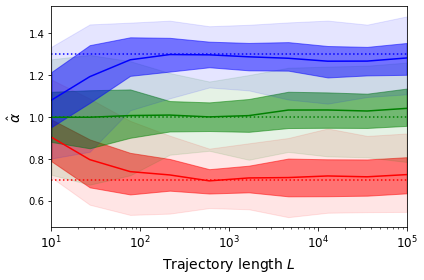

In [21]:
colors = ["red","green","blue"]
for c, _ in zip(colors, enumerate(alpha_values)):
    i, alpha = _

    plt.fill_between(x=T_values,
                     y1=[np.quantile(alpha_preds[(i,T)],0.05) for T in T_values],
                     y2=[np.quantile(alpha_preds[(i,T)],0.95) for T in T_values],alpha=.1,color=c)
    plt.fill_between(x=T_values,
                     y1=[np.quantile(alpha_preds[(i,T)],0.25) for T in T_values],
                     y2=[np.quantile(alpha_preds[(i,T)],0.75) for T in T_values],alpha=.5,color=c)

    plt.plot(T_values,[np.mean(alpha_preds[(i,T)]) for T in T_values],color=c)
    plt.axhline(alpha,c=c,ls=":")
plt.xlim((np.min(T_values),np.max(T_values)))
plt.xticks(fontsize=12)
plt.xscale("log")
plt.ylabel("$\hat{\\alpha}$",fontsize=14)
plt.xlabel("Trajectory length $L$",fontsize=14)
plt.tight_layout()
plt.savefig("%s/paper-fbm/figures/alpha_convergence.pdf" % os.environ["SCRATCH"])

# Check features

In [56]:
from gfbm.layers.features_init import TrajsFeaturesLengthInvariant, cumsum_per_graph, diff_per_graph

In [57]:
dm = DataModule(dl_params={"batch_size":3,"num_workers":4},
ds_params={"N": int(1e3),
           "dim": model.hparams["dim"],
           "length_range": (800,1200),
           #"length_range": (10,50),
           "vary_tau": False,
           "alpha_range": (1.2,1.2),
           "noise": model.hparams["noise_sigma"]},
graph_info={"edge_method": "uniform",
            "degree": model.hparams["degree"]},
no_parallel=True)

In [58]:
for batch in dm.test_dataloader(no_parallel=True):
    batch.to(model.device)
    #out = model(batch.to(model.device))
    break

Prepare datasets
seed_offset = 1000
Test dataloader


[W pthreadpool-cpp.cc:90] Warning: Leaking Caffe2 thread-pool after fork. (function pthreadpool)
[W pthreadpool-cpp.cc:90] Warning: Leaking Caffe2 thread-pool after fork. (function pthreadpool)
[W pthreadpool-cpp.cc:90] Warning: Leaking Caffe2 thread-pool after fork. (function pthreadpool)
[W pthreadpool-cpp.cc:90] Warning: Leaking Caffe2 thread-pool after fork. (function pthreadpool)


In [59]:
fm = TrajsFeaturesLengthInvariant()

In [60]:
X, E = fm(batch)

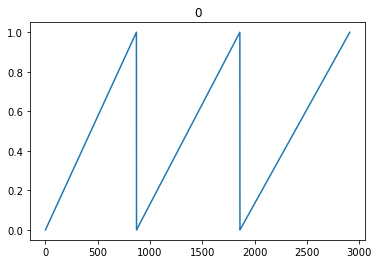

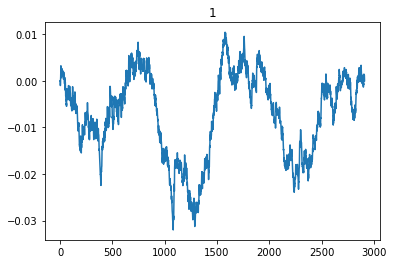

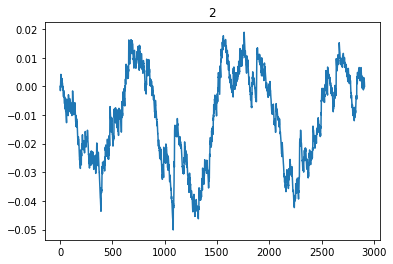

In [61]:
for c in range(X.shape[1]):
    plt.figure()
    plt.title(c)
    plt.plot(X[:,c].cpu())

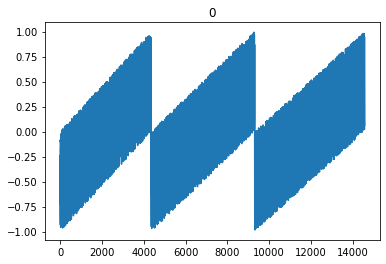

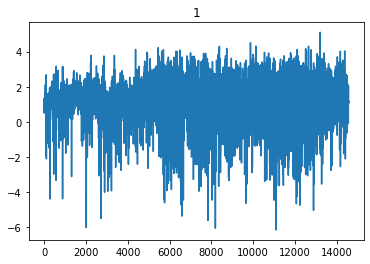

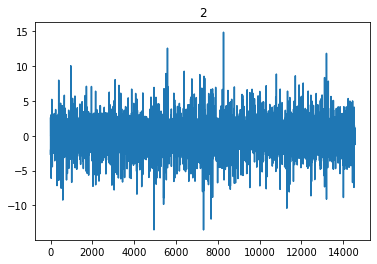

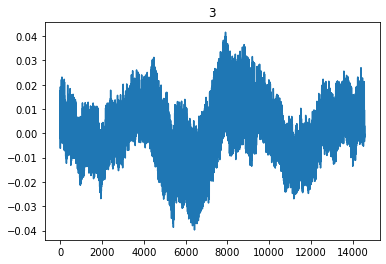

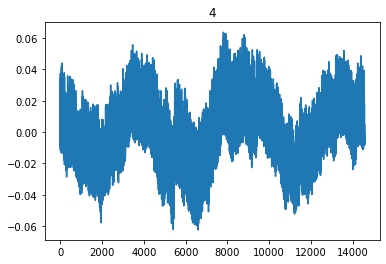

In [62]:
for c in range(E.shape[1]):
    plt.figure()
    plt.title(c)
    plt.plot(E[:,c].cpu())

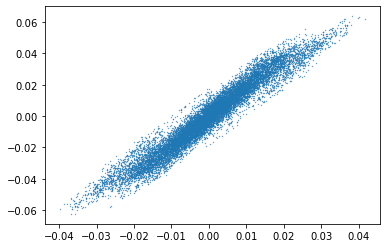

In [64]:
plt.scatter(E[:,3].cpu(),E[:,4].cpu(),s=.1)

# Experiments

In [3]:
dm = DataModule(dl_params={"batch_size":3,"num_workers":4},
ds_params={"N": int(1e2),
           "dim": 1,
           "length_range": (10,30),
           #"length_range": (10,50),
           "vary_tau": False,
           "alpha_range": (.4,1.6),
           "noise": 0.},
graph_info={"edge_method": "uniform_min_100",
            "degree": 5},
no_parallel=True)

In [4]:
encoder_params = {
        "n_c": 32,
        "latent_dim": 16,
        "alpha_range": dm.ds_params["alpha_range"],
        "length_range": dm.ds_params["length_range"],
        # Arguments about the graph are passed to the encoder
        # to allow easy initilization of the datamodule when using it to predict true data
        # They're not used ny the encoder during training, but only by the datamodule
        "edge_method": "uniform",  # "uniform_max_%d" % (hparams.L) if hparams.sparse else
        "degree": 5,
        "dim": 1,
        "scale_types": [],
        "vary_T": True,
        "vary_tau": False,
        "noise_sigma": 0.,
        "lr": 1e-4,
        "n_lengths": 16,  # n lengths for eval batches
        "T": dm.ds_params["length_range"][1],
        "skip_scales": True,
        "to_predict": "alpha",
    }

In [5]:
model = BFlowEncoder(**encoder_params)

In [6]:
trainer = pl.Trainer(auto_select_gpus=True,gpus=1,gradient_clip_val=1., accumulate_grad_batches=4)

GPU available: True, used: True
TPU available: False, using: 0 TPU cores


In [7]:
# Il faut faire attention à graph_info["edges_per_node"] VS graph_info["degree"]

In [8]:
trainer.test(model, dm.test_dataloader(no_parallel=True))

LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


seed_offset = 100


/gpfslocalsup/pub/anaconda-py3/2020.02/envs/pytorch-gpu-1.8.0/lib/python3.7/site-packages/torch_sparse/storage.py:14: UserWarning: `layout` argument unset, using default layout "coo". This may lead to unexpected behaviour.
  warnings.warn('`layout` argument unset, using default layout '



--------------------------------------------------------------------------------
DATALOADER:0 TEST RESULTS
{'training_MAE_alpha': 0.28880730271339417,
 'training_loss': 0.0936853289604187,
 'training_loss_epoch': 0.1138896718621254}
--------------------------------------------------------------------------------


[{'training_loss_epoch': 0.1138896718621254,
  'training_MAE_alpha': 0.28880730271339417,
  'training_loss': 0.0936853289604187}]

In [7]:
trainer.fit(model, dm,)

LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
Set SLURM handle signals.

  | Name           | Type                         | Params
----------------------------------------------------------------
0 | features_maker | TrajsFeaturesLengthInvariant | 0     
1 | generator      | fBMGenerator                 | 0     
2 | summary_net    | TrajsEncoder                 | 81.3 K
3 | simple_mlp     | Sequential                   | 19.3 K
----------------------------------------------------------------
100 K     Trainable params
0         Non-trainable params
100 K     Total params
0.403     Total estimated model params size (MB)


seed_offset = 0


seed_offset = 0


/gpfslocalsup/pub/anaconda-py3/2020.02/envs/pytorch-gpu-1.8.0/lib/python3.7/site-packages/pytorch_lightning/utilities/distributed.py:52: UserWarning: Detected KeyboardInterrupt, attempting graceful shutdown...
  warnings.warn(*args, **kwargs)


1

In [8]:
trainer.test(model, dm.test_dataloader(no_parallel=True))

LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


seed_offset = 20000



--------------------------------------------------------------------------------
DATALOADER:0 TEST RESULTS
{'training_MAE_alpha': 0.19500693678855896,
 'training_loss': 0.06751806288957596,
 'training_loss_epoch': 0.05902879312634468}
--------------------------------------------------------------------------------


[{'training_loss_epoch': 0.05902879312634468,
  'training_MAE_alpha': 0.19500693678855896,
  'training_loss': 0.06751806288957596}]

In [9]:
predictions = trainer.predict(model,dataloaders=dm.test_dataloader(no_parallel=True))
alpha_pred = np.concatenate([p[0] for p in predictions])
alpha_true = np.concatenate([p[1].alpha.cpu() for p in predictions])
length = np.concatenate([p[1].length.cpu() for p in predictions])

LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


seed_offset = 20000


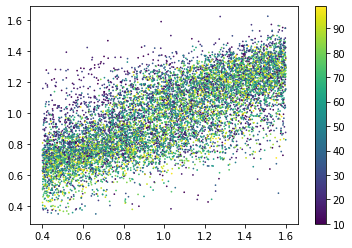

In [10]:
cm = plt.scatter(alpha_true, alpha_pred,c=length,s=.5)
plt.colorbar(cm)

In [16]:
dm_long = DataModule(dl_params={"batch_size":4,"num_workers":4},
ds_params={"N": int(1e3),
           "dim": model.hparams["dim"],
           "length_range": (10,30),
           #"length_range": (10,50),
           "vary_tau": False,
           "alpha_range": (.4,1.6),
           "noise": model.hparams["noise_sigma"]},
graph_info={"edge_method": "uniform_min_100",
            "degree": model.hparams["degree"]},
no_parallel=True)

In [1]:
predictions = trainer.predict(model,dataloaders=dm_long.test_dataloader(no_parallel=True))
alpha_pred = np.concatenate([p[0] for p in predictions])
alpha_true = np.concatenate([p[1].alpha.cpu() for p in predictions])
length = np.concatenate([p[1].length.cpu() for p in predictions])

NameError: name 'trainer' is not defined

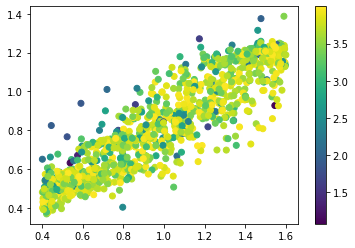

In [15]:
cm = plt.scatter(alpha_true, alpha_pred,c=np.log10(length))
plt.colorbar(cm)